In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf


#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# *** Added import for seaborn ***
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# LazyClassifier for quick model benchmarking
# !pip install lazypredict               # Install if necessary/Giving Error while importing LazyClassifier
from lazypredict.Supervised import LazyClassifier

# === PCA with RandomForest Pipeline ===

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


# ANN + SMOTE
#!pip install tensorflow     #install if needed

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# !pip install scikit-fuzzy # install if necessary
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import mode
from sklearn.metrics import silhouette_score

# For scatter matrix plots
from pandas.plotting import scatter_matrix

# For explainability analysis
import shap
import pickle

# *** Import SimpleImputer ***
from sklearn.impute import SimpleImputer

import warnings
import traceback
import time

2025-04-19 01:18:42.069837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745047122.078711   88267 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745047122.081511   88267 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745047122.088226   88267 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745047122.088235   88267 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745047122.088235   88267 computation_placer.cc:177] computation placer alr

In [2]:
# Load the Kaggle Dataset
file_path = "cybersecurity_intrusion_data.csv"
df = None # Initialize df
try:
    # Read the CSV, attempting to infer types but prepared for mixed types
    df = pd.read_csv(file_path, low_memory=False)
    print(f"Successfully loaded {file_path}")
    print(f"Original dataset shape: {df.shape}")

    # --- Data Cleaning: Handle potential mixed types more robustly ---
    # Attempt to convert obviously numeric columns that might be objects
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                # Try converting to numeric, coercing errors to NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')
                # If conversion resulted in all NaNs, maybe it wasn't numeric
                if df[col].isnull().all():
                   df_reloaded_col = pd.read_csv(file_path, usecols=[col], low_memory=False)[col]
                   df[col] = df_reloaded_col # Reload original object column
            except ValueError:
                pass # Keep as object if conversion fails
    print("Attempted conversion of object columns to numeric.")
    # df.info() # Show info after type conversion attempt
    # ------------------------------------------------------------------

    # Reduce sample size for quicker execution (like UNSW notebook)
    if df.shape[0] >= 20000:
        df = df.sample(n=20000, random_state=42).copy()
        print(f"Sampled dataset shape: {df.shape}")
    else:
        print(f"Dataset has less than 20000 rows ({df.shape[0]}), using the full dataset.")
        df = df.copy() # Ensure it's a copy

    # Preview dataset
    print("\nDataset Head:")
    display(df.head())

except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")


Successfully loaded cybersecurity_intrusion_data.csv
Original dataset shape: (9537, 11)
Attempted conversion of object columns to numeric.
Dataset has less than 20000 rows (9537), using the full dataset.

Dataset Head:


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.98,DES,0.61,1,Edge,0,1
1,SID_00002,472,TCP,3,1558.00,DES,0.30,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.04,DES,0.74,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.25,DES,0.12,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.54,AES,0.05,1,Firefox,0,0


In [3]:
# Basic EDA
if df is not None:
    print("=== Dataset Info ===")
    df.info()

    print("\n=== Statistical Summary (Numeric Columns) ===")
    display(df.describe(include=np.number))
    print("\n=== Statistical Summary (Object Columns) ===")
    display(df.describe(include=['object']))

    print("\n=== Missing Values per Column (Showing > 0) ===")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    # Define target column for Kaggle dataset
    target_col = 'attack_detected' # <<< ADAPTED FOR KAGGLE
    if target_col in df.columns:
        print(f"\n=== Target Variable ('{target_col}') Distribution ===")
        print(df[target_col].value_counts())
        print("\n--- Normalized --- ")
        print(df[target_col].value_counts(normalize=True))
    else:
        print(f"\nError: Target column '{target_col}' not found in the DataFrame.")
        target_col = None # Set target_col to None if not found
else:
    print("DataFrame 'df' not loaded. Cannot perform EDA.")

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB

=== Statistical Summary (Numeric Columns) ===


,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.00,9537.00,9537.00,9537.00,9537.00,9537.00,9537.00
mean,500.43,4.03,792.75,0.33,1.52,0.15,0.45
std,198.38,1.96,786.56,0.18,1.03,0.36,0.50
min,64.00,1.00,0.50,0.00,0.00,0.00,0.00
25%,365.00,3.00,231.95,0.19,1.00,0.00,0.00
50%,499.00,4.00,556.28,0.31,1.00,0.00,0.00
75%,635.00,5.00,1105.38,0.45,2.00,0.00,1.00
max,1285.00,13.00,7190.39,0.92,5.00,1.00,1.00



=== Statistical Summary (Object Columns) ===


,session_id,protocol_type,encryption_used,browser_type
count,9537,9537,7571,9537
unique,9537,3,2,5
top,SID_00001,TCP,AES,Chrome
freq,1,6624,4706,5137



=== Missing Values per Column (Showing > 0) ===
encryption_used    1966
dtype: int64

=== Target Variable ('attack_detected') Distribution ===
attack_detected
0    5273
1    4264
Name: count, dtype: int64

--- Normalized --- 
attack_detected
0   0.55
1   0.45
Name: proportion, dtype: float64



Identified Numeric Features: 6
Identified Categorical Features: 4

Imputing numeric features with median for plotting...
Imputing categorical features with 'Missing' for plotting...

--- Displaying Distribution for first 5 Numeric Features ---


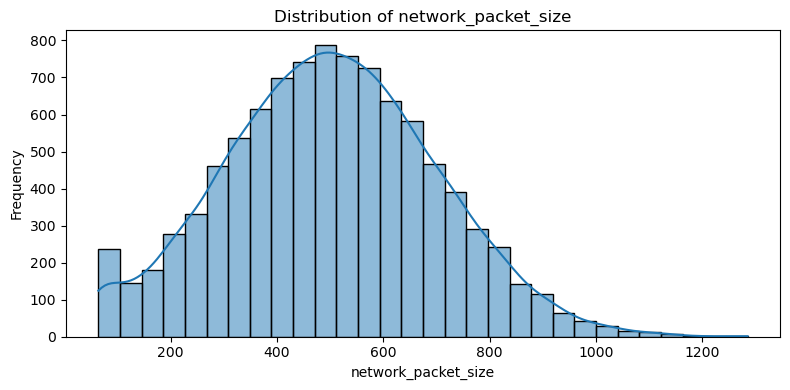

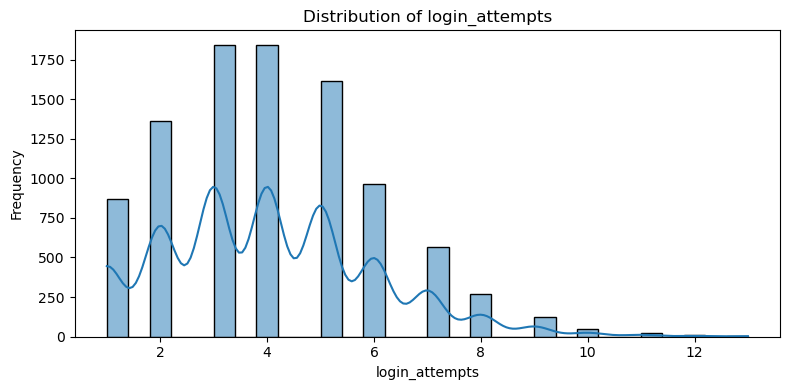

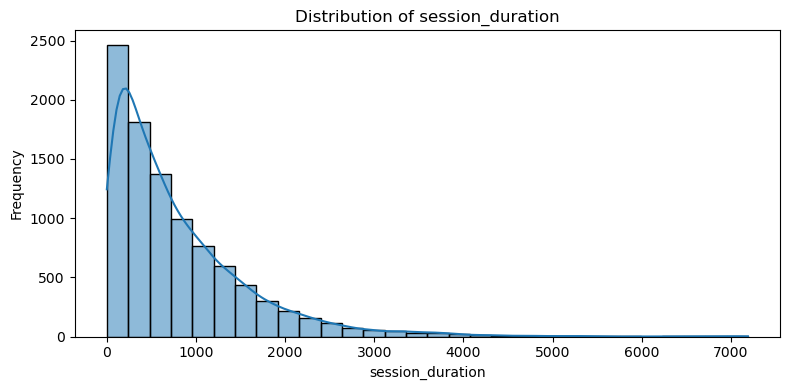

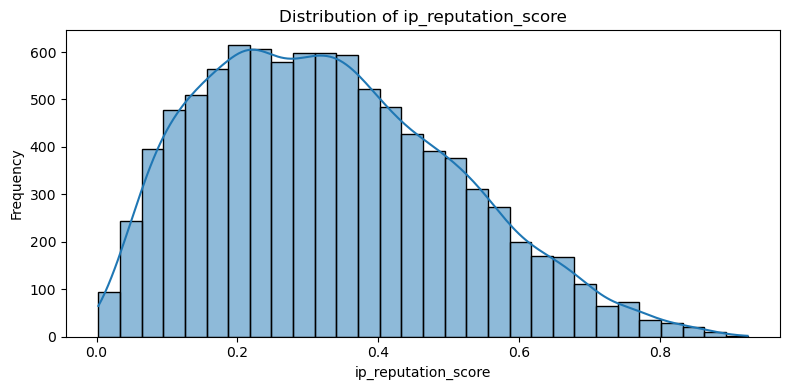

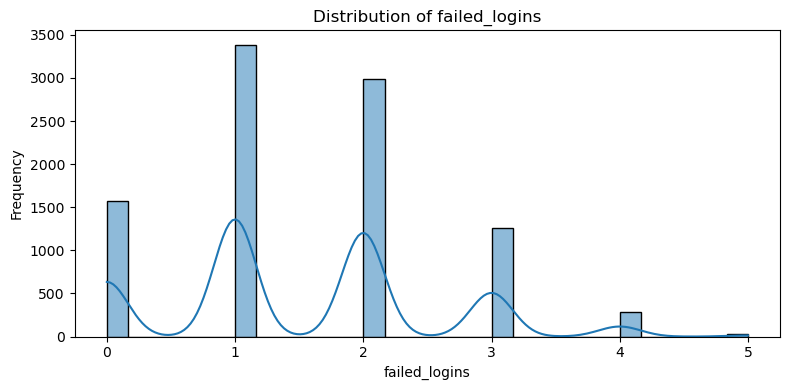


--- Displaying Boxplots for first 5 Numeric Features ---


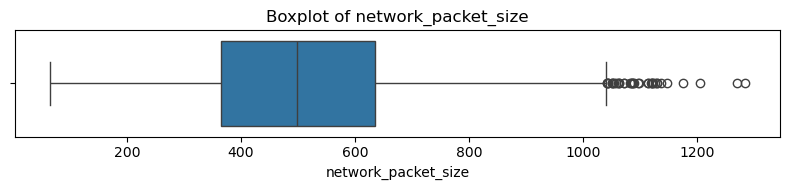

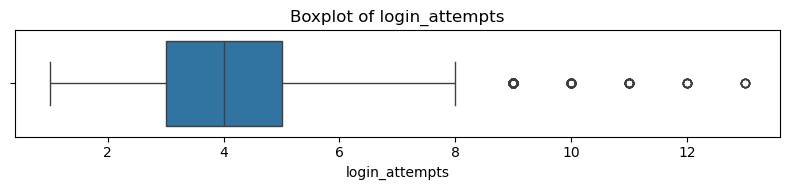

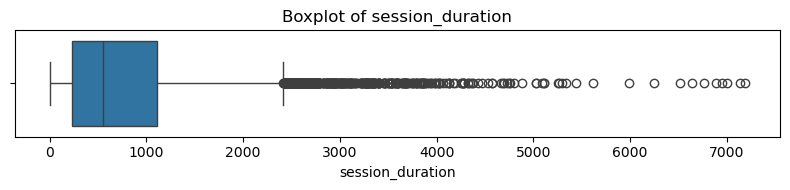

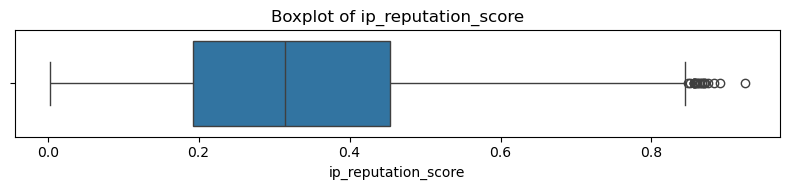

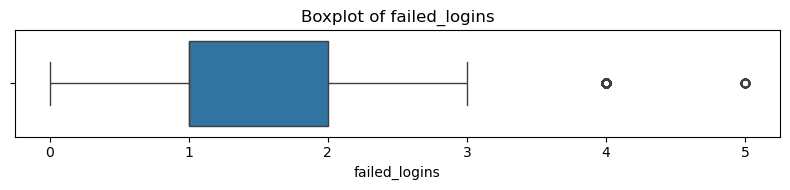

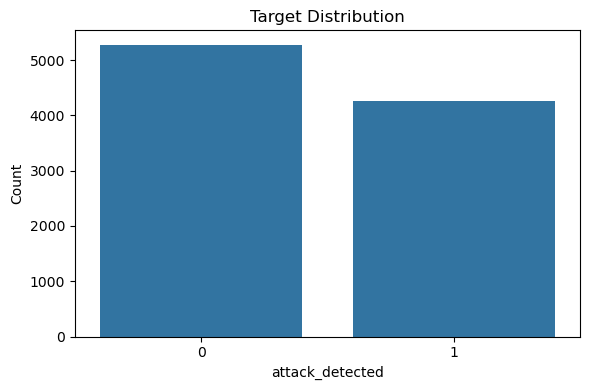


--- Correlation Matrix Heatmap (Numeric Features) ---


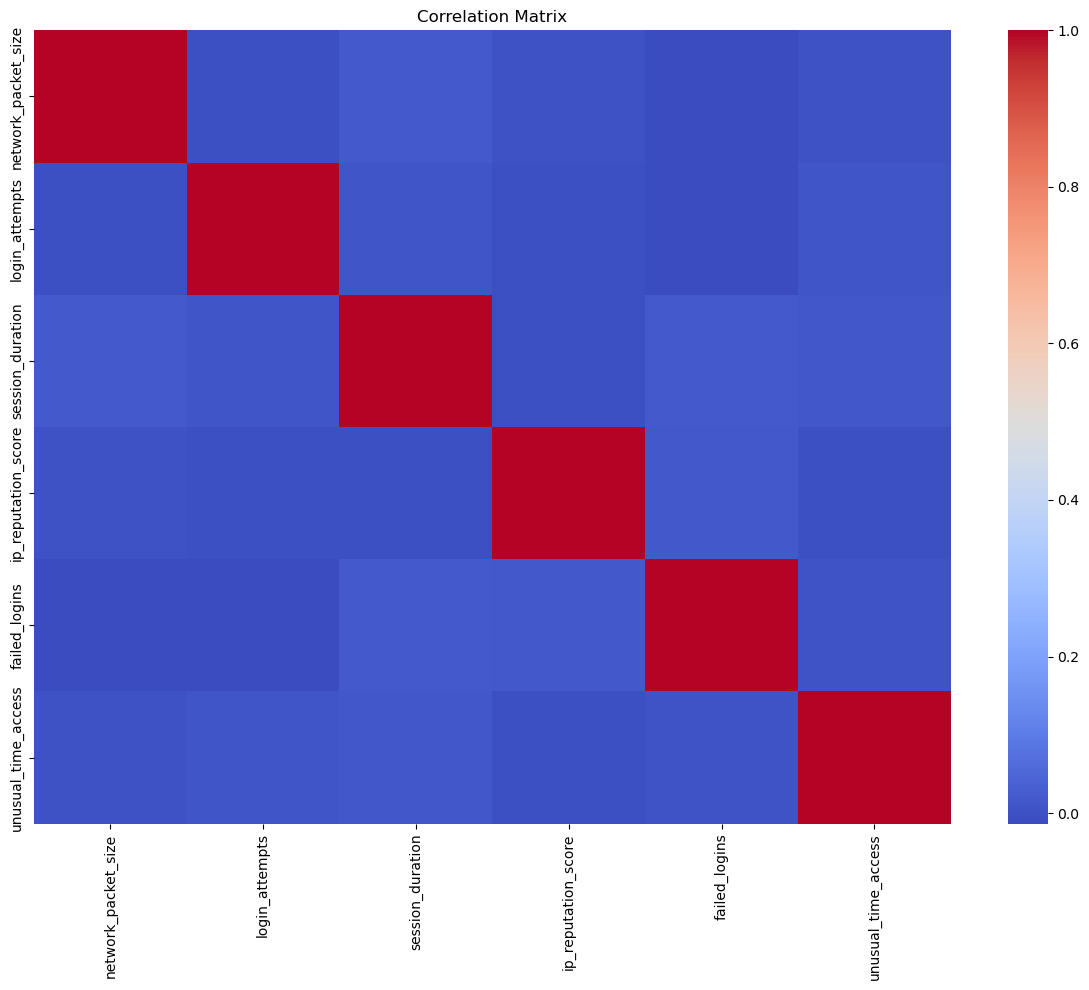


--- Scatter Matrix (Sample of Numeric Features) ---


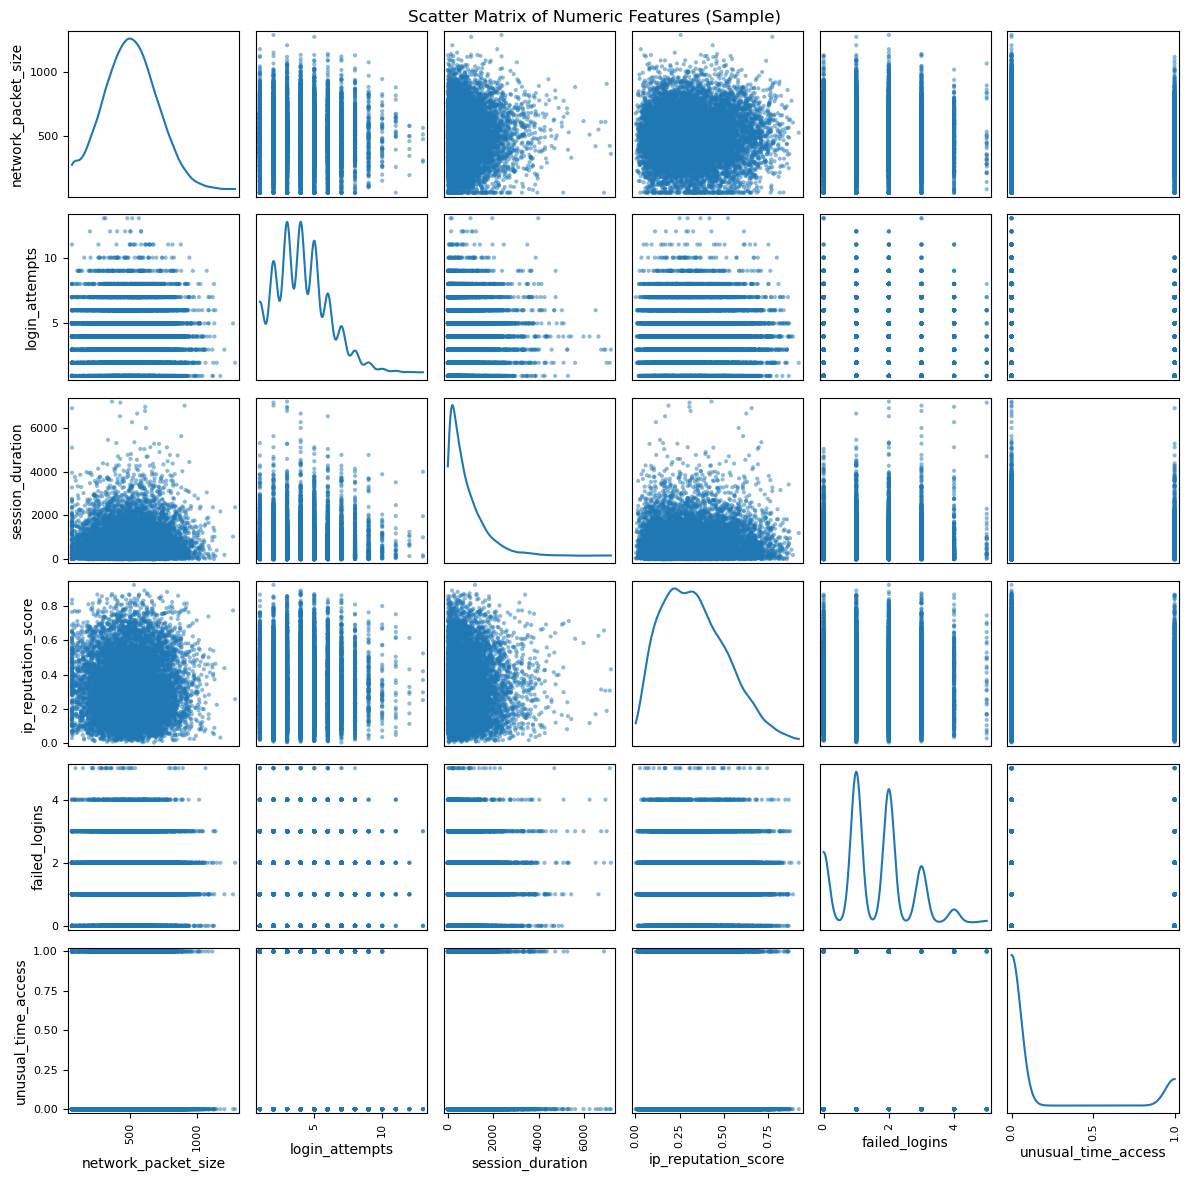

In [4]:
# Advanced EDA
if df is not None and target_col is not None:
    # Identify numeric and categorical features (excluding the target)
    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    print(f"\nIdentified Numeric Features: {len(numeric_features)}")
    print(f"Identified Categorical Features: {len(categorical_features)}")

    # --- Impute Missing Values Before Plotting ---
    df_plot = df.copy()
    if numeric_features:
        print("\nImputing numeric features with median for plotting...")
        for col in numeric_features:
            if df_plot[col].isnull().any():
                median_val = df_plot[col].median()
                df_plot[col].fillna(median_val, inplace=True)
    if categorical_features:
        print("Imputing categorical features with 'Missing' for plotting...")
        for col in categorical_features:
            if df_plot[col].isnull().any():
                df_plot[col].fillna('Missing', inplace=True)
    # ---------------------------------------------

    # Distribution plots for numeric features (show first 5)
    print("\n--- Displaying Distribution for first 5 Numeric Features ---")
    for col in numeric_features[:5]:
        plt.figure(figsize=(8, 4))
        sns.histplot(df_plot[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

    # Boxplots for numeric features to detect outliers (show first 5)
    print("\n--- Displaying Boxplots for first 5 Numeric Features ---")
    for col in numeric_features[:5]:
        plt.figure(figsize=(8, 2))
        sns.boxplot(x=df_plot[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

    # Bar plot for target variable distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df_plot[target_col])
    plt.title('Target Distribution')
    plt.xlabel(target_col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Correlation matrix heatmap for numeric features
    if numeric_features:
        print("\n--- Correlation Matrix Heatmap (Numeric Features) ---")
        corr = df_plot[numeric_features].corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, cmap='coolwarm', annot=False)
        plt.title("Correlation Matrix")
        plt.tight_layout()
        plt.show()

    # Scatter matrix (only if few numeric features)
    if 1 < len(numeric_features) <= 6:
        print("\n--- Scatter Matrix (Sample of Numeric Features) ---")
        scatter_matrix(df_plot[numeric_features[:6]], figsize=(12,12), diagonal='kde') # Plot first 6
        plt.suptitle('Scatter Matrix of Numeric Features (Sample)')
        plt.tight_layout()
        plt.show()
    elif len(numeric_features) > 6:
        print("\nSkipping scatter matrix due to large number of numeric features (>6).")
else:
    print("DataFrame 'df' or target column not available. Cannot perform Advanced EDA.")

In [5]:
# Data Preprocessing Setup
preprocessor = None
X = None
y = None
if df is not None and target_col is not None:
    # Separate features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # --- Explicitly remove potential ID / high-cardinality columns ---
    # List of columns to potentially drop (adjust based on actual dataset columns)
    cols_to_drop_ids = ['session_id'] # Drop only session_id as requested

    # Drop columns if they exist in X
    existing_cols_to_drop = [col for col in cols_to_drop_ids if col in X.columns]
    if existing_cols_to_drop:
        print(f"Dropping ID column(s): {existing_cols_to_drop}")
        X = X.drop(columns=existing_cols_to_drop)
    else:
        print("session_id column not found to drop.")
    # ------------------------------------------------------------------

    # Re-identify numeric and categorical columns from the *modified* X
    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    print("Preprocessing - Numeric features:", numeric_features)
    print("Preprocessing - Categorical features:", categorical_features)

    # Create transformers with imputation
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # Impute NaNs
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), # Impute NaNs
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

    # Build the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )
    print("\nPreprocessor with imputation defined successfully.")

    # Fit the preprocessor and show transformed shape (optional)
    try:
        # Fit *only* on X (don't transform yet, let pipelines handle that)
        preprocessor.fit(X) 
        print("Preprocessor fitted successfully.")
        # Example transform to check shape
        X_processed_example = preprocessor.transform(X.head()) # Transform a small sample
        print(f"Shape after preprocessing (example): {X_processed_example.shape}")
        # Get feature names after one-hot encoding
        try:
            cat_feature_names_out = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
            processed_feature_names = numeric_features + list(cat_feature_names_out)
            print(f"Number of features after preprocessing: {len(processed_feature_names)}")
        except Exception as e:
            print(f"Could not get feature names: {e}")
    except Exception as e:
        print(f"Error fitting/transforming with preprocessor: {e}")
        preprocessor = None

else:
    print("DataFrame 'df' or target column not available. Cannot set up preprocessing.")

Dropping ID column(s): ['session_id']
Preprocessing - Numeric features: ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access']
Preprocessing - Categorical features: ['protocol_type', 'encryption_used', 'browser_type']

Preprocessor with imputation defined successfully.
Preprocessor fitted successfully.
Shape after preprocessing (example): (5, 17)
Number of features after preprocessing: 17


In [6]:

# --- LazyClassifier with One-Hot Encoding (using main preprocessor) ---
if preprocessor is not None and X is not None and y is not None:
    try:
        print("Preparing data for LazyClassifier using the main preprocessor (One-Hot Encoding)...")
        # Split the *original* data (X should have session_id dropped already)
        X_train_lc, X_test_lc, y_train_lc, y_test_lc = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print("Data split for LazyClassifier.")

        # Apply the fitted preprocessor (imputes, scales numeric, one-hot encodes categoricals)
        print("Applying preprocessor to train and test sets...")
        X_train_lc_processed = preprocessor.transform(X_train_lc)
        X_test_lc_processed = preprocessor.transform(X_test_lc)
        print(f"Processed train shape for LazyClassifier: {X_train_lc_processed.shape}")
        print(f"Processed test shape for LazyClassifier: {X_test_lc_processed.shape}")
        print("Preprocessing complete.")

        if X_train_lc_processed.shape[1] == 0:
             print("Error: No features remaining after preprocessing.")
        else:
            print("Running LazyClassifier...")
            # Note: Scaling is already done by the preprocessor's numeric transformer
            clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
            models, predictions = clf.fit(X_train_lc_processed, X_test_lc_processed, y_train_lc, y_test_lc)

            print("\nLazyClassifier Results (Top 10 by Accuracy - Using One-Hot Encoding):")
            print(models.sort_values(by="Accuracy", ascending=False).head(10))

    except Exception as e:
        print(f"Error running LazyClassifier with One-Hot Encoding: {e}")
        traceback.print_exc()
else:
    print("Preprocessor, Features 'X', or target 'y' could not be prepared. Skipping LazyClassifier.")

# --- Main Data Split for Subsequent Models ---
# This split uses the same X (with session_id dropped) as LazyClassifier
if X is not None and y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("\nData split into Train/Test sets for subsequent models (using X with session_id dropped):")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
else:
    print("Features 'X' or target 'y' not defined. Cannot split data.")
    X_train, X_test, y_train, y_test = None, None, None, None

Preparing data for LazyClassifier using the main preprocessor (One-Hot Encoding)...
Data split for LazyClassifier.
Applying preprocessor to train and test sets...
Processed train shape for LazyClassifier: (7629, 17)
Processed test shape for LazyClassifier: (1908, 17)
Preprocessing complete.
Running LazyClassifier...


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3411, number of negative: 4218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 7629, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447110 -> initscore=-0.212356
[LightGBM] [Info] Start training from score -0.212356

LazyClassifier Results (Top 10 by Accuracy - Using One-Hot Encoding):
                        Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
LGBMClassifier              0.88               0.87     0.87      0.88   
RandomForestClassifier      0.88               0.87     0.87      0.88   
BaggingClassifier           0.88               0.87     0.87      0.88   
XGBCl

In [7]:
# Hyperparameter Tuning on RandomForest
best_model = None # Use 'best_model' as in UNSW notebook
if preprocessor is not None and X_train is not None:
    print("\n--- Hyperparameter Tuning for RandomForestClassifier --- ")
    # Build a pipeline with the preprocessor and RandomForestClassifier
    # The preprocessor used here was fitted on X *after* session_id was dropped
    pipe_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced')) # Added class_weight
    ])

    # Set up the parameter grid for GridSearchCV
    param_grid_rf = {
        'classifier__n_estimators': [100, 150], # Reduced grid
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 3]
    }

    grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=3, n_jobs=-1, scoring='accuracy', verbose=1) # Reduced CV

    try:
        # Fit the pipeline (preprocessor will be applied to X_train)
        grid_search_rf.fit(X_train, y_train)
        print("\nBest Parameters Found (RandomForest):", grid_search_rf.best_params_)
        print("Best Cross-validation Accuracy (RandomForest): {:.4f}".format(grid_search_rf.best_score_))
        best_model = grid_search_rf.best_estimator_ # Assign to best_model
    except Exception as e:
        print(f"Error during RandomForest GridSearchCV: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Preprocessor or training data not available. Skipping RandomForest Tuning.")


--- Hyperparameter Tuning for RandomForestClassifier --- 
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters Found (RandomForest): {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 150}
Best Cross-validation Accuracy (RandomForest): 0.8954



--- Evaluating Tuned RandomForest Model --- 
Accuracy: 0.8857

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.74      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.91      0.89      0.88      1908


=== Confusion Matrix ===


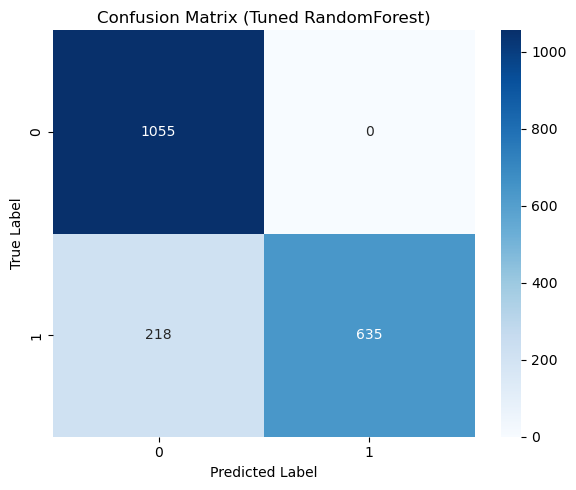

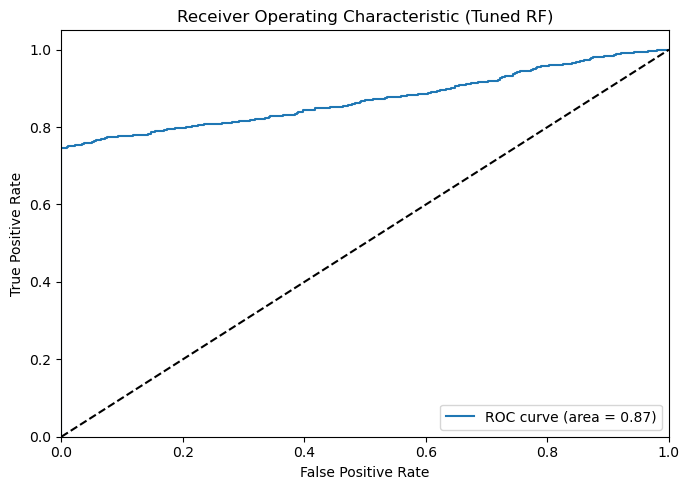

In [8]:
# Evaluate the Tuned Model
if best_model is not None and X_test is not None:
    print("\n--- Evaluating Tuned RandomForest Model --- ")
    try:
        # Predict using the best pipeline (includes preprocessing)
        y_pred = best_model.predict(X_test)
        print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
        print("\n=== Classification Report ===")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        print("\n=== Confusion Matrix ===")
        # print(cm)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (Tuned RandomForest)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        # If binary classification, plot the ROC curve.
        if len(np.unique(y)) == 2: # Check based on original y
            y_proba = best_model.predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_proba)
            roc_auc = roc_auc_score(y_test, y_proba)
            plt.figure(figsize=(7, 5))
            plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (Tuned RF)')
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error during RandomForest evaluation: {e}")
else:
    print("Tuned RandomForest model ('best_model') or test data not available. Skipping Evaluation.")


--- PCA + RandomForest Pipeline --- 
Using n_components=10 for PCA.

=== PCA + RandomForest Classification Report ===
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1055
           1       0.88      0.71      0.78       853

    accuracy                           0.82      1908
   macro avg       0.84      0.81      0.82      1908
weighted avg       0.83      0.82      0.82      1908


=== Confusion Matrix (PCA + RandomForest) ===


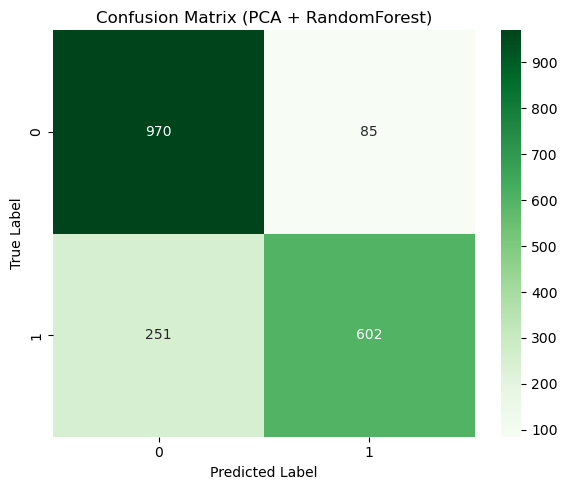

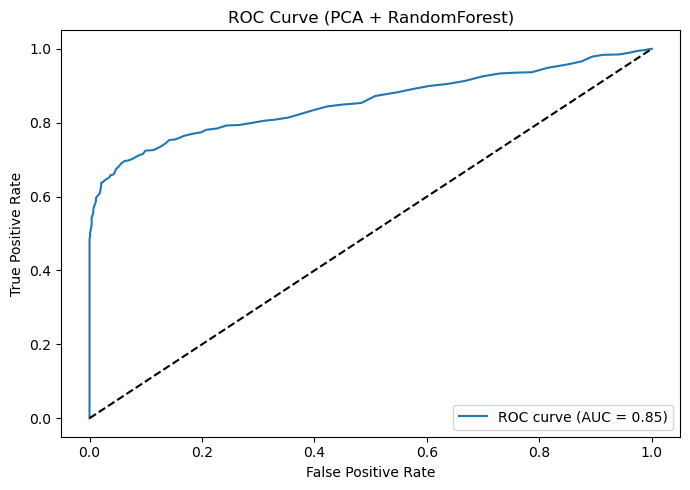

In [9]:
# === PCA with RandomForest Pipeline ===
if preprocessor is not None and X_train is not None:
    print("\n--- PCA + RandomForest Pipeline --- ")
    try:
        # Fit preprocessor first to know the number of features
        # Use the same preprocessor fitted on X with session_id dropped
        X_train_processed_pca_check = preprocessor.transform(X_train)
        n_features_after_preprocessing = X_train_processed_pca_check.shape[1]
        n_components_pca = min(10, n_features_after_preprocessing, X_train.shape[0])
        print(f"Using n_components={n_components_pca} for PCA.")

        pca = PCA(n_components=n_components_pca)
        rf_clf_pca = RandomForestClassifier(random_state=42, class_weight='balanced') # Added class_weight

        # Build pipeline: preprocessing → PCA → classifier
        pca_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('pca', pca),
            ('classifier', rf_clf_pca)
        ])

        # Fit pipeline
        pca_pipeline.fit(X_train, y_train)

        # Predict and evaluate
        y_pred_pca = pca_pipeline.predict(X_test)
        print("\n=== PCA + RandomForest Classification Report ===")
        print(classification_report(y_test, y_pred_pca))

        # Confusion matrix
        cm_pca = confusion_matrix(y_test, y_pred_pca)
        print("\n=== Confusion Matrix (PCA + RandomForest) ===")
        # print(cm_pca)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens')
        plt.title('Confusion Matrix (PCA + RandomForest)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        # ROC Curve (for binary classification)
        if len(np.unique(y)) == 2:
            y_proba_pca = pca_pipeline.predict_proba(X_test)[:, 1]
            fpr_pca, tpr_pca, thresholds_pca = roc_curve(y_test, y_proba_pca)
            roc_auc_pca = roc_auc_score(y_test, y_proba_pca)
            plt.figure(figsize=(7, 5))
            plt.plot(fpr_pca, tpr_pca, label=f'ROC curve (AUC = {roc_auc_pca:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve (PCA + RandomForest)')
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error during PCA + RandomForest pipeline: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Preprocessor or training data not available. Skipping PCA + RandomForest.")


--- ANN + SMOTE Pipeline --- 
Input dimension for ANN: 17
Shape before SMOTE: (7629, 17), Class distribution: [4218 3411]
Shape after SMOTE: (8436, 17), Class distribution: [4218 4218]


I0000 00:00:1745047141.279126   88267 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10278 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1745047141.280802   88267 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10104 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:05:00.0, compute capability: 8.6


Epoch 1/30


I0000 00:00:1745047142.215640   88498 service.cc:152] XLA service 0x725dd4008950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745047142.215675   88498 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1745047142.215682   88498 service.cc:160]   StreamExecutor device (1): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-19 01:19:02.229962: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745047142.318754   88498 cuda_dnn.cc:529] Loaded cuDNN version 90300


105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6569 - loss: 0.6299

I0000 00:00:1745047142.789934   88498 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6576 - loss: 0.6293 - val_accuracy: 0.7198 - val_loss: 0.5741
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7372 - loss: 0.5369 - val_accuracy: 0.7464 - val_loss: 0.5235
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7744 - loss: 0.4881 - val_accuracy: 0.7713 - val_loss: 0.4835
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8034 - loss: 0.4541 - val_accuracy: 0.7944 - val_loss: 0.4393
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8239 - loss: 0.4155 - val_accuracy: 0.8128 - val_loss: 0.4051
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8358 - loss: 0.4011 - val_accuracy: 0.8235 - val_loss: 0.3965
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8599 - loss: 0.3657 - val_accuracy: 0.8229 - val_loss: 0.3879
Epoch 8/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8586 - loss: 0.3636 - val_accuracy: 0.8264 - val

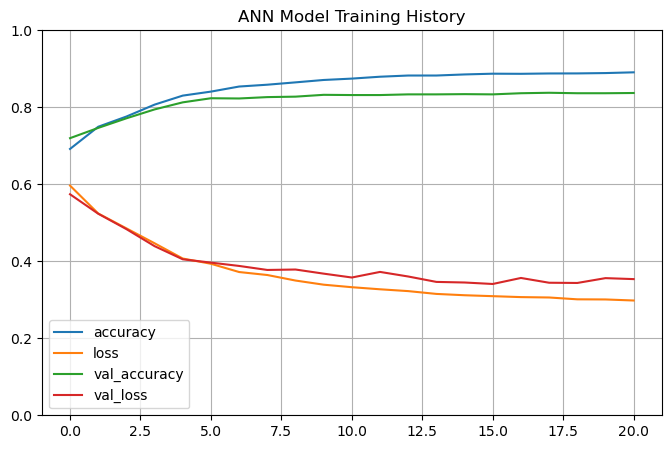

In [10]:
# === ANN + SMOTE ===
if preprocessor is not None and X_train is not None:
    print("\n--- ANN + SMOTE Pipeline --- ")
    # Define the ANN model structure
    def create_ann_model(input_shape):
        model = Sequential()
        model.add(Dense(64, input_dim=input_shape, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid')) # Binary output
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    try:
        # 1. Preprocess training and test data using the *already fitted* preprocessor
        # Preprocessor was fitted on X with session_id dropped
        X_train_processed = preprocessor.transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        input_dim_ann = X_train_processed.shape[1]
        print(f"Input dimension for ANN: {input_dim_ann}")

        # 2. Apply SMOTE only to the processed training data
        smote = SMOTE(random_state=42)
        print(f"Shape before SMOTE: {X_train_processed.shape}, Class distribution: {np.bincount(y_train)}")
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)
        print(f"Shape after SMOTE: {X_train_balanced.shape}, Class distribution: {np.bincount(y_train_balanced)}")

        # 3. Create and Train the ANN model on balanced data
        ann_model = create_ann_model(input_dim_ann)
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = ann_model.fit(
            X_train_balanced, y_train_balanced,
            validation_split=0.2,
            epochs=30,
            batch_size=64,
            callbacks=[early_stop],
            verbose=1
        )

        # 4. Evaluate the model on the processed test set
        y_pred_prob_ann = ann_model.predict(X_test_processed)
        y_pred_ann = (y_pred_prob_ann > 0.5).astype("int32")

        print("\n=== ANN + SMOTE Results ===")
        print("Accuracy (ANN + SMOTE): {:.4f}".format(accuracy_score(y_test, y_pred_ann)))
        print("\nConfusion Matrix (ANN + SMOTE):\n", confusion_matrix(y_test, y_pred_ann))
        print("\nClassification Report (ANN + SMOTE):\n", classification_report(y_test, y_pred_ann))

        # Plot training history
        pd.DataFrame(history.history).plot(figsize=(8, 5))
        plt.grid(True)
        plt.gca().set_ylim(0, 1)
        plt.title('ANN Model Training History')
        plt.show()

    except Exception as e:
        print(f"Error during ANN + SMOTE pipeline: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Preprocessor or training data not available. Skipping ANN + SMOTE.")

In [11]:
# === Fuzzy C-Means (Base Implementation) ===
if df is not None and 'numeric_features' in locals() and y is not None:
    print("\n--- Fuzzy C-Means Clustering (Base: n=2, m=2) --- ")
    try:
        # Standardize only numeric features for FCM
        # Use numeric_features identified *after* dropping session_id
        X_fcm_base = X[numeric_features].copy() 
        # Ensure no NaNs remain (impute with median)
        if X_fcm_base.isnull().sum().sum() > 0:
            print("Warning: NaNs detected in FCM features before scaling. Imputing with median.")
            imputer_fcm = SimpleImputer(strategy='median')
            X_fcm_base[:] = imputer_fcm.fit_transform(X_fcm_base)

        if X_fcm_base.shape[0] > 0: # Check if data exists
            scaler_fcm = StandardScaler()
            X_scaled_fcm_base = scaler_fcm.fit_transform(X_fcm_base)

            # Fuzzy C-Means Clustering (Base parameters)
            n_clusters_base = 2
            m_base = 2.0

            cntr_base, u_base, _, _, _, _, fpc_base = fuzz.cluster.cmeans(
                X_scaled_fcm_base.T, c=n_clusters_base, m=m_base, error=0.005, maxiter=1000, init=None, seed=42
            )

            # Assign cluster labels based on max membership
            fcm_labels_base = np.argmax(u_base, axis=0)

            # Map cluster labels to actual class labels using majority voting
            cluster_to_label_base = {}
            for cluster in range(n_clusters_base):
                cluster_mask = (fcm_labels_base == cluster)
                # Ensure cluster is not empty before calculating mode
                if np.sum(cluster_mask) > 0:
                    mode_result = mode(y[cluster_mask])
                    # Handle potential empty mode result or non-scalar mode
                    if isinstance(mode_result.mode, (np.ndarray, list)) and len(mode_result.mode) > 0:
                        majority_class = mode_result.mode[0]
                    elif not isinstance(mode_result.mode, (np.ndarray, list)):
                        majority_class = mode_result.mode # Scalar case
                    else: # Fallback if mode is empty
                         majority_class = y[cluster_mask].iloc[0] if not y[cluster_mask].empty else y.mode()[0] # Use first element or overall mode
                    cluster_to_label_base[cluster] = majority_class
                else:
                    # Handle empty cluster - assign a default label (e.g., the overall mode or -1)
                    cluster_to_label_base[cluster] = y.mode()[0] if not y.empty else -1

            # Convert fuzzy cluster labels to predicted class labels
            fcm_pred_base = np.array([cluster_to_label_base.get(label, y.mode()[0]) for label in fcm_labels_base])

            # Evaluate
            print("\n=== Base Fuzzy C-Means Results (n=2, m=2) ===")
            print("Accuracy: {:.4f}".format(accuracy_score(y, fcm_pred_base)))
            print("Confusion Matrix:\n", confusion_matrix(y, fcm_pred_base))
            print("Classification Report:\n", classification_report(y, fcm_pred_base))
            if len(np.unique(fcm_labels_base)) > 1:
                 sil_score_base = silhouette_score(X_scaled_fcm_base, fcm_labels_base)
                 print(f"Silhouette Score: {sil_score_base:.4f}")
            else:
                 print("Silhouette Score not computable (only one cluster found).")

        else:
            print("No data available for Base Fuzzy C-Means.")
    except Exception as e:
        print(f"Error during Base Fuzzy C-Means: {e}")
        import traceback
        traceback.print_exc()
else:
    print("DataFrame, numeric features, or target 'y' not available. Skipping Base Fuzzy C-Means.")


--- Fuzzy C-Means Clustering (Base: n=2, m=2) --- 

=== Base Fuzzy C-Means Results (n=2, m=2) ===
Accuracy: 0.6190
Confusion Matrix:
 [[3289 1984]
 [1650 2614]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.62      0.64      5273
           1       0.57      0.61      0.59      4264

    accuracy                           0.62      9537
   macro avg       0.62      0.62      0.62      9537
weighted avg       0.62      0.62      0.62      9537

Silhouette Score: 0.1170


In [12]:
# === Fuzzy C-Means with Hyperparameter Tuning ===
if df is not None and 'numeric_features' in locals() and y is not None:
    print("\n--- Fuzzy C-Means Clustering with Tuning --- ")
    try:
        # Standardize only numeric features for FCM
        # Use numeric_features identified *after* dropping session_id
        X_fcm = X[numeric_features].copy()
        # Ensure no NaNs remain (impute with median)
        if X_fcm.isnull().sum().sum() > 0:
            print("Warning: NaNs detected in FCM features before scaling. Imputing with median.")
            imputer_fcm = SimpleImputer(strategy='median')
            X_fcm[:] = imputer_fcm.fit_transform(X_fcm)

        if X_fcm.shape[0] > 0: # Check if data exists
            scaler_fcm = StandardScaler()
            X_scaled_fcm = scaler_fcm.fit_transform(X_fcm)

            # Fuzzy C-Means Clustering with n_clusters and m tuning
            n_clusters_range = [2, 3, 4, 5]
            m_range = [1.5, 2.0, 2.5] # Adjusted range slightly

            best_accuracy_fcm = 0
            best_params_fcm = (None, None)
            best_fcm_pred = None
            best_fcm_labels = None
            results_fcm = []

            # Loop through different n_clusters and m values
            for n in n_clusters_range:
                for m_val in m_range:
                    try:
                        # Perform fuzzy clustering
                        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
                            X_scaled_fcm.T, c=n, m=m_val, error=0.005, maxiter=1000, init=None, seed=42
                        )
                        fcm_labels = np.argmax(u, axis=0)  # Assign clusters based on max membership

                        # Map cluster labels to actual class labels using majority voting
                        cluster_to_label = {}
                        for cluster in range(n):
                            cluster_mask = (fcm_labels == cluster)
                            if np.sum(cluster_mask) > 0:
                                mode_result = mode(y[cluster_mask])
                                if isinstance(mode_result.mode, (np.ndarray, list)) and len(mode_result.mode) > 0:
                                    majority_class = mode_result.mode[0]
                                elif not isinstance(mode_result.mode, (np.ndarray, list)):
                                    majority_class = mode_result.mode
                                else:
                                     majority_class = y[cluster_mask].iloc[0] if not y[cluster_mask].empty else y.mode()[0]
                                cluster_to_label[cluster] = majority_class
                            else:
                                cluster_to_label[cluster] = y.mode()[0] if not y.empty else -1

                        fcm_pred = np.array([cluster_to_label.get(label, y.mode()[0]) for label in fcm_labels])

                        # Compute accuracy
                        accuracy_fcm = accuracy_score(y, fcm_pred)
                        sil_score = silhouette_score(X_scaled_fcm, fcm_labels) if len(np.unique(fcm_labels)) > 1 else -1
                        results_fcm.append({'n_clusters': n, 'm': m_val, 'accuracy': accuracy_fcm, 'silhouette': sil_score, 'fpc': fpc})

                        if accuracy_fcm > best_accuracy_fcm:
                            best_accuracy_fcm = accuracy_fcm
                            best_params_fcm = (n, m_val)
                            best_fcm_pred = fcm_pred
                            best_fcm_labels = fcm_labels

                    except Exception as e_inner:
                        print(f"Error during Fuzzy C-Means inner loop for n={n}, m={m_val}: {e_inner}")

            # Print tuning results
            if results_fcm:
                results_df_fcm = pd.DataFrame(results_fcm)
                print("\nFCM Tuning Results:")
                display(results_df_fcm.sort_values(by='accuracy', ascending=False))
                print(f"\nBest n_clusters: {best_params_fcm[0]}, Best m: {best_params_fcm[1]}, Best Accuracy: {best_accuracy_fcm:.4f}")
            else:
                print("\nFCM Tuning did not produce valid results.")

            # Evaluate the best configuration from tuning
            if best_fcm_pred is not None:
                print("\n=== Best Fuzzy C-Means Results (from Tuning) ===")
                print("Accuracy: {:.4f}".format(accuracy_score(y, best_fcm_pred)))
                print("Confusion Matrix:\n", confusion_matrix(y, best_fcm_pred))
                print("Classification Report:\n", classification_report(y, best_fcm_pred))
                if len(np.unique(best_fcm_labels)) > 1:
                    sil_score_best = silhouette_score(X_scaled_fcm, best_fcm_labels)
                    print(f"Silhouette Score (Best): {sil_score_best:.4f}")
                else:
                    print("Silhouette Score not computable (only one cluster found).")
            else:
                print("\nCould not determine best FCM configuration from tuning.")
        else:
            print("No data available for Fuzzy C-Means after preprocessing.")
    except Exception as e:
        print(f"Error during Fuzzy C-Means setup: {e}")
        import traceback
        traceback.print_exc()
else:
    print("DataFrame, numeric features, or target 'y' not available. Skipping Fuzzy C-Means.")


--- Fuzzy C-Means Clustering with Tuning --- 

FCM Tuning Results:


,n_clusters,m,accuracy,silhouette,fpc
7,4,2.00,0.68,0.08,0.25
8,4,2.50,0.65,0.08,0.25
3,3,1.50,0.64,0.12,0.41
10,5,2.00,0.64,0.06,0.20
11,5,2.50,0.63,0.05,0.20
4,3,2.00,0.63,0.11,0.33
6,4,1.50,0.62,0.11,0.35
0,2,1.50,0.62,0.12,0.55
1,2,2.00,0.62,0.12,0.50
5,3,2.50,0.62,0.11,0.33



Best n_clusters: 4, Best m: 2.0, Best Accuracy: 0.6801

=== Best Fuzzy C-Means Results (from Tuning) ===
Accuracy: 0.6801
Confusion Matrix:
 [[3100 2173]
 [ 878 3386]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.59      0.67      5273
           1       0.61      0.79      0.69      4264

    accuracy                           0.68      9537
   macro avg       0.69      0.69      0.68      9537
weighted avg       0.70      0.68      0.68      9537

Silhouette Score (Best): 0.0804



--- SHAP Analysis for Tuned RandomForest Model --- 
Number of features for SHAP: 17
Calculating SHAP values for 100 samples...
SHAP calculation took 0.21 seconds.
Shape of shap_values: (100, 17, 2)
SHAP values format: Single array (samples, features, classes).

=== Mean Absolute SHAP Values (Feature Importance) ===
failed_logins             0.19
ip_reputation_score       0.10
login_attempts            0.09
browser_type_Unknown      0.03
session_duration          0.01
browser_type_Chrome       0.01
encryption_used_AES       0.01
network_packet_size       0.00
browser_type_Firefox      0.00
unusual_time_access       0.00
browser_type_Edge         0.00
encryption_used_Missing   0.00
encryption_used_DES       0.00
protocol_type_UDP         0.00
protocol_type_TCP         0.00
browser_type_Safari       0.00
protocol_type_ICMP        0.00
dtype: float64

=== Top 10 Most Important Features ===
failed_logins          0.19
ip_reputation_score    0.10
login_attempts         0.09
browser_type_Unk

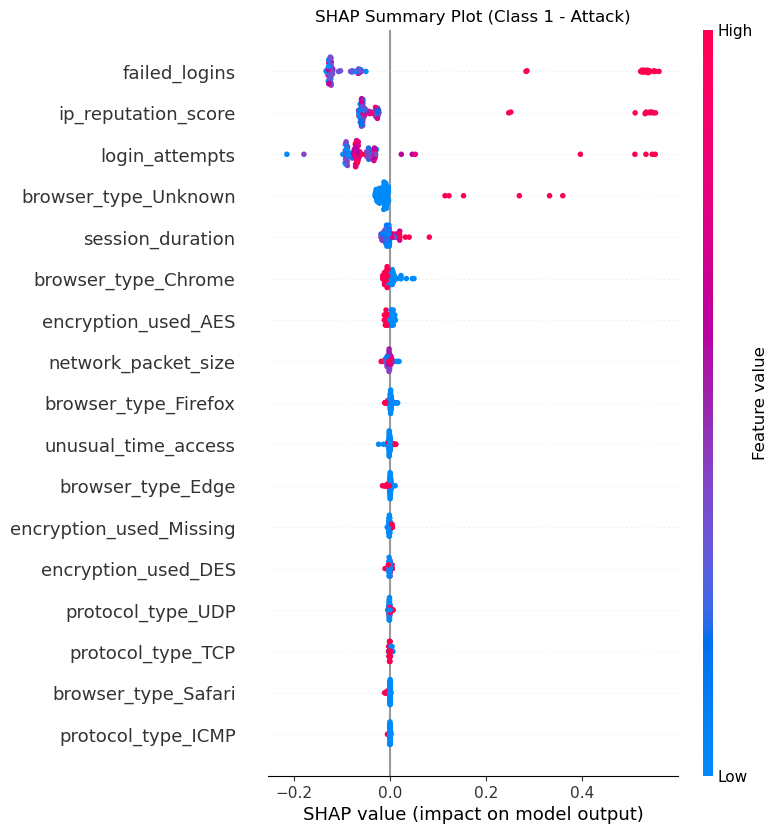

In [13]:
# === SHAP Explainability Analysis (using best RandomForest model 'best_model') ===
if best_model is not None and X_test is not None and preprocessor is not None:
    print("\n--- SHAP Analysis for Tuned RandomForest Model --- ")
    try:
        # 1. Get the fitted preprocessor and classifier from the best RF pipeline
        fitted_preprocessor = best_model.named_steps['preprocessor']
        classifier_shap = best_model.named_steps['classifier']

        # 2. Transform the test set using the *same* preprocessor
        X_test_transformed_shap = fitted_preprocessor.transform(X_test)

        # 3. Get feature names after preprocessing
        processed_feature_names_shap = None
        try:
            # Get numeric and categorical feature names *as used by the fitted preprocessor*
            numeric_features_tf = fitted_preprocessor.transformers_[0][2]
            categorical_features_tf = fitted_preprocessor.transformers_[1][2]
            ohe_transformer = fitted_preprocessor.named_transformers_['cat']['onehot']
            cat_feature_names_shap = ohe_transformer.get_feature_names_out(categorical_features_tf)
            processed_feature_names_shap = list(numeric_features_tf) + list(cat_feature_names_shap)
            print(f"Number of features for SHAP: {len(processed_feature_names_shap)}")
        except Exception as e:
            print(f"Could not retrieve feature names for SHAP: {e}. Using generic names.")
            num_processed_features = X_test_transformed_shap.shape[1]
            processed_feature_names_shap = [f'feature_{i}' for i in range(num_processed_features)]

        # 4. Create SHAP Explainer
        explainer = shap.TreeExplainer(classifier_shap)

        # 5. Calculate SHAP values (use a sample for speed)
        # Convert transformed data to DataFrame with feature names for SHAP
        X_test_transformed_df_shap = pd.DataFrame(X_test_transformed_shap, columns=processed_feature_names_shap)

        sample_size_shap = min(100, X_test_transformed_df_shap.shape[0])
        if sample_size_shap > 0:
            X_sample_shap = X_test_transformed_df_shap.sample(sample_size_shap, random_state=42)
            print(f"Calculating SHAP values for {sample_size_shap} samples...")
            start_time_shap = time.time()
            # Calculate SHAP values
            shap_values = explainer.shap_values(X_sample_shap)
            end_time_shap = time.time()
            print(f"SHAP calculation took {end_time_shap - start_time_shap:.2f} seconds.")
            print(f"Shape of shap_values: {np.shape(shap_values)}") # Debug print

            # --- Calculate and Print SHAP Feature Importance ---
            shap_values_for_importance = None
            shap_values_for_plot = None
            plot_title = "SHAP Summary Plot"

            # Check the structure of shap_values
            if isinstance(shap_values, list) and len(shap_values) == 2:
                # Handles case where output is a list [shap_class_0, shap_class_1]
                print("SHAP values format: List of arrays per class.")
                shap_values_for_importance = shap_values[1] # Use class 1 for importance
                shap_values_for_plot = shap_values[1]
                plot_title = "SHAP Summary Plot (Class 1 - Attack)"
            elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3 and shap_values.shape[-1] == 2:
                # Handles case where output is a single array (samples, features, classes)
                print("SHAP values format: Single array (samples, features, classes).")
                shap_values_for_importance = shap_values[:, :, 1] # Use class 1 slice for importance
                shap_values_for_plot = shap_values[:, :, 1]
                plot_title = "SHAP Summary Plot (Class 1 - Attack)"
            elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2 and shap_values.shape == (sample_size_shap, len(processed_feature_names_shap)):
                 # Handles case where output might be just for the positive class already
                 print("SHAP values format: Single array (samples, features) - assuming positive class.")
                 shap_values_for_importance = shap_values
                 shap_values_for_plot = shap_values
                 plot_title = "SHAP Summary Plot (Assumed Positive Class)"
            else:
                print(f"Error: Unexpected SHAP values structure. Shape: {np.shape(shap_values)}")
                shap_values_for_importance = None


            if shap_values_for_importance is not None:
                # Ensure we have a 2D array (samples, features) before calculating mean
                if shap_values_for_importance.ndim == 2 and shap_values_for_importance.shape[1] == len(processed_feature_names_shap):
                    mean_abs_shap = np.abs(shap_values_for_importance).mean(axis=0)

                    if mean_abs_shap.ndim == 1 and len(mean_abs_shap) == len(processed_feature_names_shap):
                        feature_importance = pd.Series(mean_abs_shap, index=processed_feature_names_shap)
                        feature_importance_sorted = feature_importance.sort_values(ascending=False)

                        print("\n=== Mean Absolute SHAP Values (Feature Importance) ===")
                        print(feature_importance_sorted)

                        print("\n=== Top 10 Most Important Features ===")
                        print(feature_importance_sorted.head(10))
                    else:
                         print(f"Error: Could not create feature importance Series. Mean absolute SHAP shape: {mean_abs_shap.shape}, Number of feature names: {len(processed_feature_names_shap)}")
                else:
                    print(f"Error: SHAP values for importance calculation have unexpected shape: {shap_values_for_importance.shape}")

            else:
                print("Error: Failed to extract SHAP values for importance calculation.")
            # -------------------------------------------------

            # 6. Generate SHAP summary plot
            print(f"\n=== {plot_title} ===")
            if shap_values_for_plot is not None:
                 try:
                     # Check if plot_values has the expected structure for summary_plot
                     if isinstance(shap_values_for_plot, np.ndarray) and shap_values_for_plot.shape == (sample_size_shap, len(processed_feature_names_shap)):
                          shap.summary_plot(shap_values_for_plot, X_sample_shap, show=False)
                          plt.title(plot_title)
                          plt.show()
                     else:
                          print(f"Warning: SHAP values for plotting have unexpected shape {getattr(shap_values_for_plot, 'shape', 'N/A')}. Skipping summary plot.")

                 except Exception as plot_err:
                      print(f"Error generating SHAP summary plot: {plot_err}")
            else:
                 print("Error: SHAP values for plotting are not available. Skipping summary plot.")


        else:
            print("Not enough samples to calculate SHAP values.")

    except Exception as e:
        print(f"An error occurred during SHAP analysis: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Best RandomForest model ('best_model'), test data, or preprocessor not available. Skipping SHAP analysis.")